In [ ]:
import jax
import jax.numpy as jnp
from chewc.population import quick_haplo
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno
from chewc.cross import make_cross
from chewc.predict import gblup_predict
from chewc.population import combine_populations, Population
import matplotlib.pyplot as plt
from chewc.population import quick_haplo, combine_populations, Population, subset_population # Add subset_population


# Step 1: Create a founder population using quick_haplo
print("Step 1: Creating founder population...")

# Set up parameters as specified
n_ind = 100
n_chr = 5
n_loci_per_chr = 200

# Create JAX random key
key = jax.random.PRNGKey(42)
key, pop_key = jax.random.split(key)

# Create founder population and genetic map
founder_pop, genetic_map = quick_haplo(
    key=pop_key,
    n_ind=n_ind,
    n_chr=n_chr,
    n_loci_per_chr=n_loci_per_chr,
    ploidy=2,
    inbred=False
)

print(f"Created founder population: {founder_pop}")
print(f"Genetic map shape: {genetic_map.shape}")
print(f"Genotype array shape: {founder_pop.geno.shape}")

# Step 2: Initialize SimParam from the founder population
print("\nStep 2: Creating simulation parameters...")

sp = SimParam.from_founder_pop(founder_pop, genetic_map)
print(f"SimParam: {sp}")

# Step 3: Add a quantitative trait
print("\nStep 3: Adding quantitative trait...")

# Set trait parameters as specified
n_qtl_per_chr = 50
trait_mean = jnp.array([100.0])  # Single trait with mean 100
trait_var = jnp.array([10.0])    # Genetic variance of 10

key, trait_key = jax.random.split(key)

# Add the trait to simulation parameters
sp = add_trait_a(
    key=trait_key,
    founder_pop=founder_pop,
    sim_param=sp,
    n_qtl_per_chr=n_qtl_per_chr,
    mean=trait_mean,
    var=trait_var,
    gamma=False  # Use normal distribution
)

print(f"Updated SimParam with traits: {sp}")
print(f"Number of traits: {sp.n_traits}")

# Step 4: Set phenotypes with heritability
print("\nStep 4: Setting phenotypes...")

h2 = 0.3  # Heritability as specified
key, pheno_key = jax.random.split(key)

# Set phenotypes for the population
founder_pop = set_pheno(
    key=pheno_key,
    pop=founder_pop,
    traits=sp.traits,
    ploidy=sp.ploidy,
    h2=jnp.array([h2])
)

print(f"Updated population with phenotypes: {founder_pop}")
print(f"Phenotype shape: {founder_pop.pheno.shape}")

# Step 5: Display summary statistics
print("\nStep 5: Summary statistics...")

# Calculate basic statistics
bv_mean = jnp.mean(founder_pop.bv)
bv_var = jnp.var(founder_pop.bv)
pheno_mean = jnp.mean(founder_pop.pheno)
pheno_var = jnp.var(founder_pop.pheno)

print(f"Breeding value mean: {bv_mean:.2f}")
print(f"Breeding value variance: {bv_var:.2f}")
print(f"Phenotype mean: {pheno_mean:.2f}")
print(f"Phenotype variance: {pheno_var:.2f}")
print(f"Realized heritability: {bv_var/pheno_var:.3f} (target: {h2})")

print("\nChunk 1 complete! Population created with:")
print(f"- {n_ind} individuals")
print(f"- {n_chr} chromosomes")
print(f"- {n_loci_per_chr} loci per chromosome")
print(f"- {n_qtl_per_chr} QTL per chromosome")
print(f"- Trait mean: {float(trait_mean[0])}")
print(f"- Genetic variance: {float(trait_var[0])}")
print(f"- Heritability: {h2}")

# CHUNK 2: Selection and Crossing Protocol
print("\n" + "="*50)
print("CHUNK 2: Selection and Crossing")
print("="*50)

# Step 1: Select top 20% of individuals based on phenotype
print("\nStep 1: Selecting elite founders...")
n_elite = int(0.20 * n_ind)  # 20% of 100 = 20 individuals
print(f"Selecting top {n_elite} individuals from {n_ind} founders")

# Sort by phenotype and get top 20 individuals
phenotype_values = founder_pop.pheno[:, 0]  # First (and only) trait
elite_indices = jnp.argsort(phenotype_values)[-n_elite:]  # Top 20 indices
elite_indices = jnp.sort(elite_indices)  # Sort for consistent ordering

print(f"Elite founder indices: {elite_indices}")
print(f"Elite phenotype range: {phenotype_values[elite_indices].min():.2f} to {phenotype_values[elite_indices].max():.2f}")

# Step 2: Create factorial mating design (10 sires x 10 dams = 100 crosses)
print("\nStep 2: Creating factorial mating design...")
n_sires = 10
n_dams = 10

# Split elite founders into sires and dams
sire_indices = elite_indices[:n_sires]   # First 10 elite individuals as sires
dam_indices = elite_indices[n_sires:]    # Last 10 elite individuals as dams

print(f"Sires: {sire_indices}")
print(f"Dams: {dam_indices}")

# Create cross plan: every sire with every dam
cross_plan = []
for sire_idx in sire_indices:
    for dam_idx in dam_indices:
        cross_plan.append([sire_idx, dam_idx])

cross_plan = jnp.array(cross_plan)
print(f"Cross plan shape: {cross_plan.shape}")
print(f"Number of unique crosses: {cross_plan.shape[0]}")

# Step 3: Generate 5 offspring per cross (total 500 individuals)
print("\nStep 3: Generating offspring...")
n_offspring_per_cross = 5
total_offspring = cross_plan.shape[0] * n_offspring_per_cross

print(f"Generating {n_offspring_per_cross} offspring per cross")
print(f"Total offspring expected: {total_offspring}")

# We need to expand the cross plan to account for multiple offspring per cross
expanded_cross_plan = []
for i in range(cross_plan.shape[0]):
    for j in range(n_offspring_per_cross):
        expanded_cross_plan.append(cross_plan[i])
expanded_cross_plan = jnp.array(expanded_cross_plan)

print(f"Expanded cross plan shape: {expanded_cross_plan.shape}")

# Generate offspring using make_cross
key, cross_key = jax.random.split(key)
next_id_start = founder_pop.nInd  # Start IDs after founder population

training_pop = make_cross(
    key=cross_key,
    pop=founder_pop,
    cross_plan=expanded_cross_plan,
    sp=sp,
    next_id_start=next_id_start
)

print(f"Training population created: {training_pop}")
print(f"Training population size: {training_pop.nInd}")

# Step 4: Set phenotypes for training population
print("\nStep 4: Setting phenotypes for training population...")
key, train_pheno_key = jax.random.split(key)

training_pop = set_pheno(
    key=train_pheno_key,
    pop=training_pop,
    traits=sp.traits,
    ploidy=sp.ploidy,
    h2=jnp.array([h2])
)

# Display training population statistics
print("\nTraining Population Statistics:")
train_bv_mean = jnp.mean(training_pop.bv)
train_bv_var = jnp.var(training_pop.bv)
train_pheno_mean = jnp.mean(training_pop.pheno)
train_pheno_var = jnp.var(training_pop.pheno)

print(f"Training BV mean: {train_bv_mean:.2f}")
print(f"Training BV variance: {train_bv_var:.2f}")
print(f"Training phenotype mean: {train_pheno_mean:.2f}")
print(f"Training phenotype variance: {train_pheno_var:.2f}")
print(f"Training realized heritability: {train_bv_var/train_pheno_var:.3f}")

# Compare founder vs training populations
print("\nFounder vs Training Comparison:")
print(f"Founder phenotype mean: {pheno_mean:.2f} | Training phenotype mean: {train_pheno_mean:.2f}")
print(f"Expected improvement from selection: {jnp.mean(phenotype_values[elite_indices]) - pheno_mean:.2f}")

print("\nChunk 2 complete! Created training population with:")
print(f"- {total_offspring} offspring")
print(f"- From {n_elite} elite founders ({n_sires} sires x {n_dams} dams)")
print(f"- {n_offspring_per_cross} offspring per cross")
print(f"- Factorial mating design")

# CHUNK 3: GBLUP Model Fitting
print("\n" + "="*50)
print("CHUNK 3: GBLUP Model Fitting")
print("="*50)

print("\nFitting GBLUP model to training population...")

# Fit GBLUP model using the training population
# The gblup_predict function will use the phenotypes and genotypes to estimate breeding values
prediction_results = gblup_predict(
    pop=training_pop, 
    h2=h2,  # Use the same heritability as used for phenotype generation
    trait_idx=0  # First (and only) trait
)

print(f"GBLUP model fitted successfully!")
print(f"Prediction results: {type(prediction_results)}")

# Extract GEBVs and other results
gebvs = prediction_results.ebv
reliability = prediction_results.reliability
pev = prediction_results.pev

# Update training population with GEBVs
training_pop = training_pop.replace(ebv=gebvs)

print(f"GEBVs stored in training population")
print(f"GEBV shape: {gebvs.shape}")

# Calculate accuracy statistics
print("\nGBLUP Model Performance:")
true_bv = training_pop.bv[:, 0]
pred_gebv = gebvs[:, 0]

# Calculate correlation between true BV and GEBV (accuracy)
# Remove any NaN values for correlation calculation
valid_mask = ~jnp.isnan(pred_gebv)
if jnp.sum(valid_mask) > 1:
    correlation = jnp.corrcoef(true_bv[valid_mask], pred_gebv[valid_mask])[0, 1]
    mean_reliability = jnp.nanmean(reliability)
    
    print(f"Prediction accuracy (correlation): {correlation:.3f}")
    print(f"Mean reliability: {mean_reliability:.3f}")
    print(f"Individuals with predictions: {jnp.sum(valid_mask)} / {training_pop.nInd}")
else:
    print("Warning: Insufficient valid predictions for accuracy calculation")

# Summary statistics for GEBVs
print(f"\nGEBV Statistics:")
print(f"GEBV mean: {jnp.nanmean(pred_gebv):.2f}")
print(f"GEBV variance: {jnp.nanvar(pred_gebv):.2f}")
print(f"GEBV range: {jnp.nanmin(pred_gebv):.2f} to {jnp.nanmax(pred_gebv):.2f}")

# Compare with true breeding values
print(f"\nTrue BV vs GEBV Comparison:")
print(f"True BV mean: {jnp.mean(true_bv):.2f} | GEBV mean: {jnp.nanmean(pred_gebv):.2f}")
print(f"True BV var: {jnp.var(true_bv):.2f} | GEBV var: {jnp.nanvar(pred_gebv):.2f}")

print("\nChunk 3 complete! GBLUP model fitted with:")
print(f"- Genomic relationship matrix from {training_pop.nInd} individuals")
print(f"- {jnp.sum(~jnp.isnan(training_pop.geno.reshape(training_pop.nInd, -1))).item()} total genotype observations")
print(f"- Heritability: {h2}")
print(f"- GEBVs stored in training_pop.ebv")

# CHUNK 4: Selection and Genomic Prediction Pipeline
print("\n" + "="*50)
print("CHUNK 4: Selection and Genomic Prediction Pipeline")
print("="*50)

# Step 1: Select top 20% (100 individuals) from training population based on phenotype
print("\nStep 1: Selecting top 20% from training population...")
n_selected = int(0.20 * training_pop.nInd)  # 20% of 500 = 100 individuals
print(f"Selecting top {n_selected} individuals from {training_pop.nInd} training individuals")

# Sort by phenotype and get top 100 individuals
train_phenotypes = training_pop.pheno[:, 0]
selected_indices = jnp.argsort(train_phenotypes)[-n_selected:]
selected_indices = jnp.sort(selected_indices)

print(f"Selected individuals: {len(selected_indices)}")
print(f"Phenotype range of selected: {train_phenotypes[selected_indices].min():.2f} to {train_phenotypes[selected_indices].max():.2f}")

# Step 2: Randomly pair them without resampling for 50 pairs
print("\nStep 2: Creating random pairs...")
key, pair_key = jax.random.split(key)

# Shuffle the selected indices and pair them
shuffled_indices = jax.random.permutation(pair_key, selected_indices)
n_pairs = n_selected // 2  # 100 // 2 = 50 pairs

pairs = shuffled_indices.reshape(n_pairs, 2)
print(f"Created {n_pairs} random pairs")
print(f"Pair examples: {pairs[:3]}")  # Show first 3 pairs

# Step 3: Generate 20 offspring per pair (total 1000 individuals)
print("\nStep 3: Generating offspring from pairs...")
n_offspring_per_pair = 20
total_new_offspring = n_pairs * n_offspring_per_pair

print(f"Generating {n_offspring_per_pair} offspring per pair")
print(f"Total new offspring expected: {total_new_offspring}")

# Expand pairs to create cross plan for all offspring
expanded_pairs = []
for pair in pairs:
    for _ in range(n_offspring_per_pair):
        expanded_pairs.append(pair)
expanded_pairs = jnp.array(expanded_pairs)

print(f"Expanded cross plan shape: {expanded_pairs.shape}")

# Generate offspring using make_cross
key, offspring_key = jax.random.split(key)
next_id_start = training_pop.nInd + founder_pop.nInd  # Continue ID numbering

new_generation = make_cross(
    key=offspring_key,
    pop=training_pop,
    cross_plan=expanded_pairs,
    sp=sp,
    next_id_start=next_id_start
)

print(f"New generation created: {new_generation}")
print(f"New generation size: {new_generation.nInd}")

# Step 4: Predict GEBVs using the fitted GBLUP model
print("\nStep 4: Predicting GEBVs for new generation...")

# First, we need to set up the new generation with the training population's genetic architecture
# The GBLUP model was trained on the training population, so we need to apply it to predict the new generation

# For GBLUP prediction, we need to combine genotypes and use the trained model
# Since gblup_predict expects phenotypes, we'll set dummy phenotypes (NaN) for prediction-only individuals
new_generation_with_dummies = new_generation.replace(
    pheno=jnp.full((new_generation.nInd, 1), jnp.nan),  # No phenotypes yet
    bv=jnp.zeros((new_generation.nInd, sp.n_traits)),  # Initialize BV
    ebv=jnp.zeros((new_generation.nInd, 1))  # Initialize EBV with zeros (will be overwritten)
)

# We need to create a combined population for GBLUP that includes both training data and new individuals
# This is a common approach in genomic prediction
print("Creating combined population for GBLUP prediction...")

# Combine genotypes
combined_geno = jnp.concatenate([training_pop.geno, new_generation.geno], axis=0)

# Combine phenotypes (training has real phenotypes, new generation has NaN)
combined_pheno = jnp.concatenate([training_pop.pheno, new_generation_with_dummies.pheno], axis=0)

# Create combined population object for prediction
# We need to properly handle ALL arrays to match the new population size
combined_pop_for_prediction = Population(
    geno=combined_geno,
    pheno=combined_pheno,
    id=jnp.concatenate([training_pop.id, new_generation.id]),
    iid=jnp.arange(combined_geno.shape[0]),  # Reset internal IDs
    mother=jnp.concatenate([training_pop.mother, new_generation.mother]),
    father=jnp.concatenate([training_pop.father, new_generation.father]),
    sex=jnp.concatenate([training_pop.sex, new_generation.sex]),
    fixEff=jnp.concatenate([training_pop.fixEff, new_generation_with_dummies.fixEff]),  # Fix: combine fixEff arrays
    bv=jnp.concatenate([training_pop.bv, new_generation_with_dummies.bv]),
    ebv=jnp.concatenate([training_pop.ebv, new_generation_with_dummies.ebv])  # Now both are non-None
)

print(f"Combined population size: {combined_pop_for_prediction.nInd}")

# Predict GEBVs for the combined population
combined_predictions = gblup_predict(
    pop=combined_pop_for_prediction,
    h2=h2,  # Use same heritability
    trait_idx=0
)

# Extract predictions for the new generation only
new_gen_start_idx = training_pop.nInd
new_gen_gebvs = combined_predictions.ebv[new_gen_start_idx:]
new_gen_reliability = combined_predictions.reliability[new_gen_start_idx:]

# Update new generation with GEBVs
new_generation = new_generation.replace(ebv=new_gen_gebvs)

print(f"GEBVs predicted for new generation")
print(f"New generation GEBV mean: {jnp.nanmean(new_gen_gebvs):.2f}")
print(f"New generation GEBV range: {jnp.nanmin(new_gen_gebvs):.2f} to {jnp.nanmax(new_gen_gebvs):.2f}")

# Step 5: Select top 5% based on GEBVs
print("\nStep 5: Selecting top 5% based on GEBVs...")
n_elite_new = int(0.05 * total_new_offspring)  # 5% of 1000 = 50 individuals
print(f"Selecting top {n_elite_new} individuals from {total_new_offspring} new offspring")

# Select based on GEBVs
new_gen_gebv_values = new_gen_gebvs[:, 0]
elite_new_indices = jnp.argsort(new_gen_gebv_values)[-n_elite_new:]

print(f"Selected {len(elite_new_indices)} elite individuals")
print(f"Elite GEBV range: {new_gen_gebv_values[elite_new_indices].min():.2f} to {new_gen_gebv_values[elite_new_indices].max():.2f}")

# Step 6: Subset into new population object
print("\nStep 6: Creating elite population subset...")
elite_new_pop = Population(
    geno=new_generation.geno[elite_new_indices],
    id=new_generation.id[elite_new_indices],
    iid=jnp.arange(len(elite_new_indices)),  # Reset internal IDs for new population
    mother=new_generation.mother[elite_new_indices],
    father=new_generation.father[elite_new_indices],
    sex=new_generation.sex[elite_new_indices],
    pheno=jnp.zeros((len(elite_new_indices), 1)),  # Will be set in next step
    fixEff=jnp.zeros(len(elite_new_indices), dtype=jnp.float32),
    bv=jnp.zeros((len(elite_new_indices), sp.n_traits)),  # Will be calculated when phenotyped
    ebv=new_generation.ebv[elite_new_indices]
)

print(f"Elite population created: {elite_new_pop}")

# Step 7: Phenotype with heritability of 0.6
print("\nStep 7: Setting phenotypes with h² = 0.6...")
h2_new = 0.6
key, elite_pheno_key = jax.random.split(key)

elite_new_pop = set_pheno(
    key=elite_pheno_key,
    pop=elite_new_pop,
    traits=sp.traits,
    ploidy=sp.ploidy,
    h2=jnp.array([h2_new])
)

print(f"Elite population phenotyped with h² = {h2_new}")
print(f"Elite phenotype mean: {jnp.mean(elite_new_pop.pheno):.2f}")
print(f"Elite phenotype variance: {jnp.var(elite_new_pop.pheno):.2f}")

# Step 8: Combine with training population
print("\nStep 8: Combining elite population with training population...")


# Combine training population with elite new population
final_combined_pop = combine_populations(
    training_pop, 
    elite_new_pop, 
    new_id_start=jnp.max(training_pop.id) + 1
)

print(f"Final combined population: {final_combined_pop}")
print(f"Combined population size: {final_combined_pop.nInd}")
print(f"Training portion: {training_pop.nInd} individuals")
print(f"Elite new portion: {elite_new_pop.nInd} individuals")

print("\nChunk 4 complete! Selection pipeline finished with:")
print(f"- Selected top 20% ({n_selected}) from training population")
print(f"- Created {n_pairs} random pairs")
print(f"- Generated {total_new_offspring} offspring ({n_offspring_per_pair} per pair)")
print(f"- Predicted GEBVs using GBLUP model")
print(f"- Selected top 5% ({n_elite_new}) based on GEBVs")
print(f"- Phenotyped elite with h² = {h2_new}")
print(f"- Combined into final population of {final_combined_pop.nInd} individuals")

In [ ]:
import jax
import jax.numpy as jnp
from chewc.population import quick_haplo
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno
from chewc.cross import make_cross
from chewc.predict import gblup_predict
from chewc.population import combine_populations, Population
import matplotlib.pyplot as plt
from chewc.population import quick_haplo, combine_populations, Population, subset_population # Add subset_population


In [ ]:
plt.hist(elite_new_pop.bv,alpha=.5)
plt.hist(founder_pop.bv,alpha=.5)

--- SETUP PHASE ---
Step 2.1: Creating founder population...
Step 2.2: Adding quantitative trait...
Step 2.3: Setting phenotypes for founders...
Founder population created with 100 individuals.

--- ESTABLISHMENT PHASE ---
Step 3.1: Selecting elite founders...
Step 3.2: Generating training population...
Step 3.3: Phenotyping training population...
Training population created with 500 individuals.

--- RECURRENT SELECTION LOOP ---

--- Generation 1 ---
  Training GBLUP model on 500 individuals...
  Selecting 100 parents based on GEBVs...
  Generating 1000 candidates...
  Calculating true BVs for 1000 candidates...
  Predicting GEBVs for 1000 candidates...
  Selecting top 100 elites from candidates...
  Phenotyping elites with h2=0.6...
  Updating training population with new elites...
  Trimming training population to most recent 500 individuals...
  Generation 1 complete. Mean True BV: 12.437

--- Generation 2 ---
  Training GBLUP model on 500 individuals...
  Selecting 100 parents bas

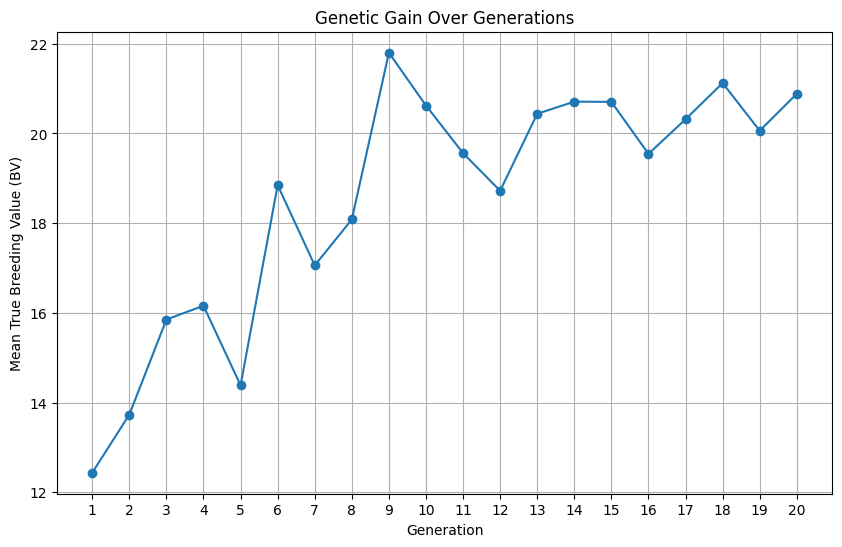

In [7]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt

# Import chewc library components
from chewc.population import quick_haplo, combine_populations, Population, subset_population
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno, set_bv
from chewc.cross import make_cross
from chewc.predict import gblup_predict
# =============================================================================
# 1. SIMULATION CONFIGURATION
# =============================================================================
# All parameters are defined here for easy modification and reproducibility.
config = {
    "simulation": {
        "seed": 42,
        "n_generations": 20,
    },
    "founder": {
        "n_ind": 100,
        "n_chr": 5,
        "n_loci_per_chr": 200,
    },
    "trait": {
        "n_qtl_per_chr": 50,
        "mean": jnp.array([100.0]),
        "var": jnp.array([10.0]),
        # CHANGE 1: Increased heritability for a clearer signal
        "h2_initial": 0.5,
    },
    "breeding_program": {
        # --- Stage 1: Creating the Training Population ---
        "n_elite_founders": 20,
        "n_offspring_per_founder_cross": 5,
        "training_population_size": 500,
        
        # --- Stage 2: The Recurrent Selection Cycle ---
        "parent_selection_criterion": "ebv",
        "n_parents_per_generation": 100,
        # CHANGE 2: Adjusted offspring to create a standard 1000-candidate pool
        "n_offspring_per_cross": 20,
        # CHANGE 3: Increased elites to improve training data relevance
        "n_elite_selections_per_generation": 100, 
        "h2_elite_phenotyping": 0.6,
    }
}



# =============================================================================
# 2. SETUP PHASE: FOUNDER POPULATION AND TRAIT DEFINITION
# =============================================================================
print("--- SETUP PHASE ---")

# Initialize JAX random key
key = jax.random.PRNGKey(config["simulation"]["seed"])

# Create founder population
print("Step 2.1: Creating founder population...")
key, pop_key = jax.random.split(key)
founder_pop, genetic_map = quick_haplo(
    key=pop_key,
    n_ind=config["founder"]["n_ind"],
    n_chr=config["founder"]["n_chr"],
    n_loci_per_chr=config["founder"]["n_loci_per_chr"]
)

# Initialize SimParam
sp = SimParam.from_founder_pop(founder_pop, genetic_map)

# Add a quantitative trait
print("Step 2.2: Adding quantitative trait...")
key, trait_key = jax.random.split(key)
sp = add_trait_a(
    key=trait_key,
    founder_pop=founder_pop,
    sim_param=sp,
    n_qtl_per_chr=config["trait"]["n_qtl_per_chr"],
    mean=config["trait"]["mean"],
    var=config["trait"]["var"]
)

# Set initial phenotypes for founders
print("Step 2.3: Setting phenotypes for founders...")
key, pheno_key = jax.random.split(key)
founder_pop = set_pheno(
    key=pheno_key,
    pop=founder_pop,
    traits=sp.traits,
    ploidy=sp.ploidy,
    h2=jnp.array([config["trait"]["h2_initial"]])
)
print(f"Founder population created with {founder_pop.nInd} individuals.")

# =============================================================================
# 3. ESTABLISHMENT PHASE: CREATE INITIAL TRAINING POPULATION
# =============================================================================
print("\n--- ESTABLISHMENT PHASE ---")

# Select top founders based on phenotype
print("Step 3.1: Selecting elite founders...")
pheno_values = founder_pop.pheno[:, 0]
elite_indices = jnp.argsort(pheno_values)[-config["breeding_program"]["n_elite_founders"]:]

# Create a factorial mating design (10 sires x 10 dams)
sires = elite_indices[:len(elite_indices)//2]
dams = elite_indices[len(elite_indices)//2:]
cross_plan = jnp.array([[s, d] for s in sires for d in dams])

# Expand cross plan for multiple offspring per cross using jnp.repeat for efficiency
expanded_cross_plan = jnp.repeat(
    cross_plan, 
    repeats=config["breeding_program"]["n_offspring_per_founder_cross"], 
    axis=0
)

# Generate the training population
print("Step 3.2: Generating training population...")
key, cross_key = jax.random.split(key)
training_pop = make_cross(
    key=cross_key,
    pop=founder_pop,
    cross_plan=expanded_cross_plan,
    sp=sp,
    next_id_start=founder_pop.nInd
)

# Phenotype the training population
print("Step 3.3: Phenotyping training population...")
key, pheno_key = jax.random.split(key)
training_pop = set_pheno(
    key=pheno_key,
    pop=training_pop,
    traits=sp.traits,
    ploidy=sp.ploidy,
    h2=jnp.array([config["trait"]["h2_initial"]])
)
print(f"Training population created with {training_pop.nInd} individuals.")

# =============================================================================
# 4. RECURRENT SELECTION LOOP
# =============================================================================
print("\n--- RECURRENT SELECTION LOOP ---")

history = []
current_training_pop = training_pop

for gen in range(config["simulation"]["n_generations"]):
    print(f"\n--- Generation {gen + 1} ---")

    # Step 4.1: Train GBLUP model on the current training population
    print(f"  Training GBLUP model on {current_training_pop.nInd} individuals...")
    gblup_results = gblup_predict(pop=current_training_pop, h2=config["trait"]["h2_initial"])
    current_training_pop = current_training_pop.replace(ebv=gblup_results.ebv)
    
    # Step 4.2: Select parents for the next generation
    n_parents = config["breeding_program"]["n_parents_per_generation"]
    if config["breeding_program"]["parent_selection_criterion"] == "ebv":
        print(f"  Selecting {n_parents} parents based on GEBVs...")
        selection_values = current_training_pop.ebv[:, 0]
    else:
        print(f"  Selecting {n_parents} parents based on Phenotypes...")
        selection_values = current_training_pop.pheno[:, 0]
    
    parent_indices = jnp.argsort(selection_values)[-n_parents:]

    # Step 4.3: Create mating plan and generate selection candidates
    print(f"  Generating {config['breeding_program']['n_offspring_per_cross'] * (n_parents//2)} candidates...")
    key, pair_key, cross_key = jax.random.split(key, 3)
    shuffled_parents = jax.random.permutation(pair_key, parent_indices)
    pairs = shuffled_parents.reshape(n_parents // 2, 2)
    
    candidate_cross_plan = jnp.repeat(
        pairs, 
        repeats=config["breeding_program"]["n_offspring_per_cross"], 
        axis=0
    )
    
    # After Step 4.3 where you create the candidates
    candidates = make_cross(
        key=cross_key,
        pop=current_training_pop,
        cross_plan=candidate_cross_plan,
        sp=sp,
        next_id_start=jnp.max(current_training_pop.id) + 1
    )

    # --- NEWLY ADDED STEP ---
    # Calculate the true breeding values for the new candidates
    print(f"  Calculating true BVs for {candidates.nInd} candidates...")
    candidates = set_bv(
        pop=candidates,
        traits=sp.traits,
        ploidy=sp.ploidy
    )
    # Step 4.4: Predict GEBVs for the unphenotyped candidates
    print(f"  Predicting GEBVs for {candidates.nInd} candidates...")
    # Create a temporary version of candidates with NaN phenotypes for prediction
    candidates_for_pred = candidates.replace(pheno=jnp.full((candidates.nInd, sp.n_traits), jnp.nan))
    
    # Combine with training data and predict
    combined_pop = combine_populations(current_training_pop, candidates_for_pred)
    combined_preds = gblup_predict(pop=combined_pop, h2=config["trait"]["h2_initial"])
    
    # Extract GEBVs for candidates only
    candidate_gebvs = combined_preds.ebv[current_training_pop.nInd:]
    candidates = candidates.replace(ebv=candidate_gebvs)

    # Step 4.5: Select the top elite individuals from the candidates
    n_elites = config["breeding_program"]["n_elite_selections_per_generation"]
    print(f"  Selecting top {n_elites} elites from candidates...")
    elite_indices = jnp.argsort(candidates.ebv[:, 0])[-n_elites:]
    
    # Create a new population of only the elite selections
    elite_pop = subset_population(candidates, elite_indices)
    
    # Step 4.6: Phenotype the selected elites with high accuracy
    print(f"  Phenotyping elites with h2={config['breeding_program']['h2_elite_phenotyping']}...")
    key, elite_pheno_key = jax.random.split(key)
    elite_pop = set_pheno(
        key=elite_pheno_key,
        pop=elite_pop,
        traits=sp.traits,
        ploidy=sp.ploidy,
        h2=jnp.array([config["breeding_program"]["h2_elite_phenotyping"]])
    )

    # ... inside your main loop ...

    # Step 4.7: Update the training population for the next cycle
    print("  Updating training population with new elites...")

    # First, get the size of the training pop BEFORE adding new elites
    # This will be our target size for the moving window
    training_pop_size = current_training_pop.nInd 

    # Combine the old training data with the new elites
    updated_pop = combine_populations(current_training_pop, elite_pop)

    # --- THE CRITICAL FIX ---
    # Keep only the most recent individuals to maintain a fixed-size "moving window"
    # This prevents the accumulation of selection bias over many generations.
    print(f"  Trimming training population to most recent {training_pop_size} individuals...")
    current_training_pop = subset_population(updated_pop, jnp.arange(-training_pop_size, 0))
    # The slice jnp.arange(-training_pop_size, 0) selects the *last* N individuals.

    # Step 4.8: Log results for this generation
    # ... rest of the code is the same ...
    # Step 4.8: Log results for this generation
    # We log the state of the *candidate* population before selection
    results = {
        "generation": gen + 1,
        "mean_true_bv": jnp.mean(candidates.bv).item(),
        "var_true_bv": jnp.var(candidates.bv).item(),
        "mean_predicted_gebv": jnp.nanmean(candidates.ebv).item(),
        "prediction_accuracy": jnp.corrcoef(candidates.bv[:, 0], candidates.ebv[:, 0])[0, 1].item()
    }
    history.append(results)
    print(f"  Generation {gen + 1} complete. Mean True BV: {results['mean_true_bv']:.3f}")

# =============================================================================
# 5. ANALYSIS AND VISUALIZATION
# =============================================================================
print("\n--- ANALYSIS ---")

# Convert history to a pandas DataFrame for easy analysis
results_df = pd.DataFrame(history)
print(results_df)

# Plot the genetic gain over time
plt.figure(figsize=(10, 6))
plt.plot(results_df['generation'], results_df['mean_true_bv'], marker='o', linestyle='-')
plt.title('Genetic Gain Over Generations')
plt.xlabel('Generation')
plt.ylabel('Mean True Breeding Value (BV)')
plt.grid(True)
plt.xticks(results_df['generation'])
plt.show()

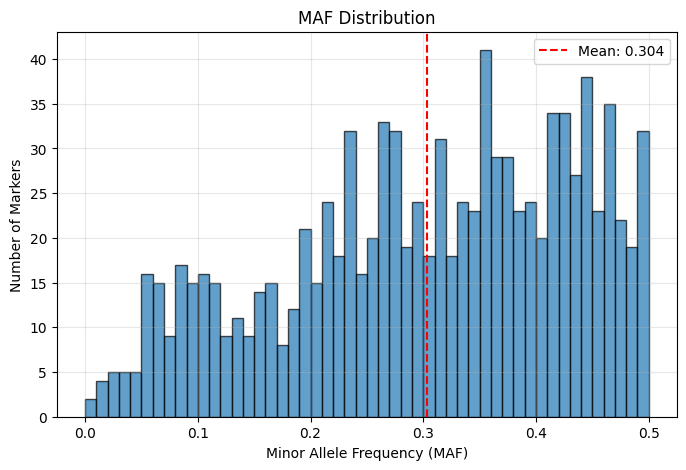

Markers: 1000 | Fixed: 1 | Mean MAF: 0.304


In [8]:
current_training_pop.plot_maf()

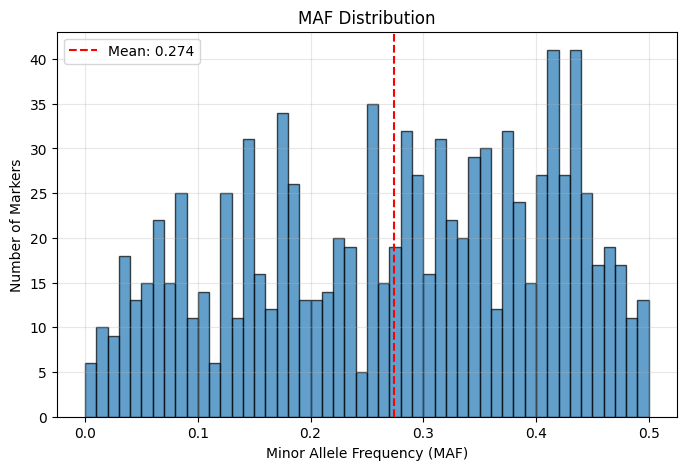

Markers: 1000 | Fixed: 5 | Mean MAF: 0.274


In [9]:
elite_pop.plot_maf()